In this Python script we have written code for anime-style image transformation using pre-trained ONNX models based on the AnimeGAN architecture. It first downloads the animeGAN repository and installs necessary dependencies like OpenCV, NumPy, and ONNX Runtime. The script includes functions for loading models, processing images (resizing and normalizing), converting real-world images to anime style using the loaded models, and displaying the original and transformed images side by side for comparison. Here, we are trying to transform images to dragon ball z cartoon style.

In [ ]:
from google.colab import drive, output
import torch
dv = torch.cuda.get_device_name(0)
print(dv)

drive.mount('/content/drive/', force_remount=False)
repo = "Pytorch-animeGAN"
%cd "/content"
!rm -rf {repo}
!git clone https://github.com/ptran1203/{repo}
%cd {repo}
output.clear()

In [ ]:

import os
import urllib

data_path = 'anime-gan.zip'
dataset_url = 'https://github.com/ptran1203/pytorch-animeGAN/releases/download/v1.0/dataset_v1.zip'

if not os.path.exists("/content/drive/MyDrive/dataset"):
    !wget -O {data_path} {dataset_url}
    !unzip {data_path} -d /content
    !rm {data_path}

    if not os.path.exists("/content/drive/MyDrive/dataset"):
        raise ValueError(f"Download Failed, {data_path}")

output.clear()

In [ ]:
working_dir = '/content/drive/MyDrive/animeGAN'
ckp_dir = f'{working_dir}/checkpoints'
save_img_dir = f'{working_dir}/generated_samples'
print(f"You're running on {dv}")

You're running on Tesla V100-SXM2-16GB


# Training Stage

In [ ]:
!python3 train.py --dataset 'DBZ'\
                  --data-dir '/content/drive/MyDrive/dataset/'\
                  --epochs 50\
                  --batch 2\
                  --debug-samples 0\
                  --init-epochs 0\
                  --checkpoint-dir {ckp_dir}\
                  --save-image-dir {save_img_dir}\
                  --save-interval 1\
                  --gan-loss lsgan\
                  --init-lr 0.0001\
                  --lr-g 0.00002\
                  --lr-d 0.00004\
                  --wadvd 10.0\
                  --wadvg 10.0\
                  --wcon 1.5\
                  --wgra 3.0\
                  --wcol 70.0\
                  --resume GD\

# ==== Train Config ==== #
dataset DBZ
data_dir /content/drive/MyDrive/dataset/
epochs 50
init_epochs 0
batch_size 2
checkpoint_dir /content/drive/MyDrive/animeGAN/checkpoints
save_image_dir /content/drive/MyDrive/animeGAN/generated_samples
gan_loss lsgan
resume GD\
use_sn False
save_interval 1
debug_samples 0
lr_g 2e-05
lr_d 4e-05
init_lr 0.0001
wadvg 10.0
wadvd 10.0
wcon 1.5
wgra 3.0
wcol 70.0
d_layers 3
d_noise False
Init models...
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` t

In [ ]:
from inference import Transformer
transformer = Transformer(ckp_dir + '/generator_DBZ.pth')

Weight loaded, ready to predict


# Inference Stage

(1, 512, 768, 3)
(1, 512, 768, 3)


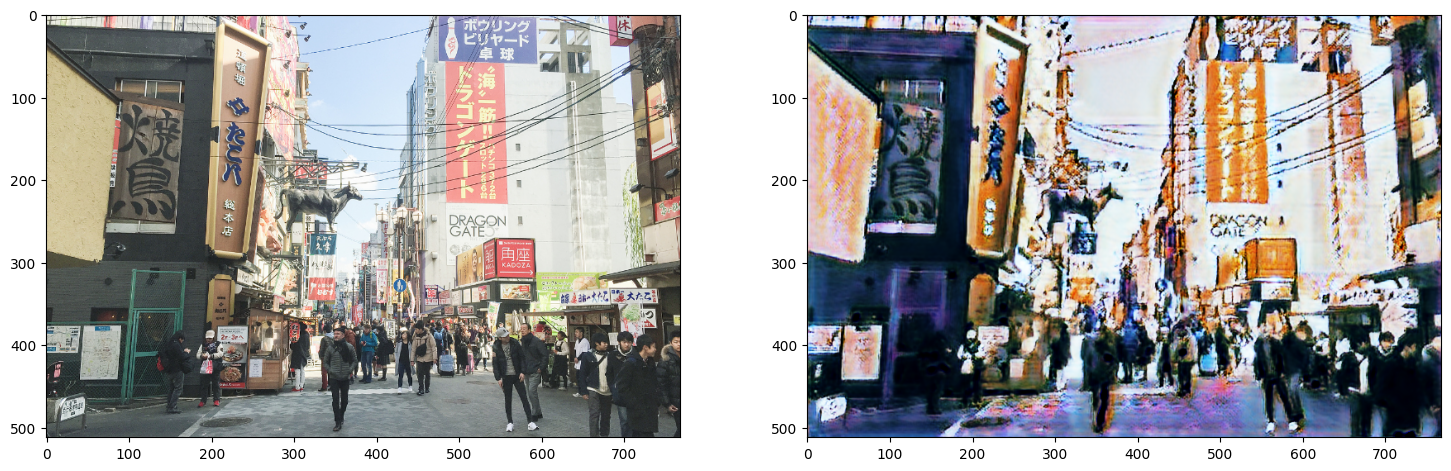

In [ ]:
import cv2
import random
import matplotlib.pyplot as plt
import numpy as np
import os
def random_img(img_dir):
    # p = '/content/test_4.png'
    p = os.path.join(img_dir, random.choice(os.listdir(img_dir)))
    return cv2.imread(p)[:, :, ::-1]

image1 = plt.imread('/content/drive/MyDrive/dataset/test/HR_photo/1 (32).jpg')
image1 = image1[:,:,0:3]
image1 = cv2.resize(image1, (768, 512))
image = image1 / 0.5 - 1
image = image * 127.5 + 127.5
# print(np.unique(image))


anime_img = (transformer.transform(image) + 1) / 2
print(anime_img.shape)
anime_img
# image1 = cv2.resize(image1, (256, 256))
# anime_img = cv2.resize(anime_img[0], (256, 256))
print(anime_img.shape)
fig = plt.figure(figsize=(18, 25))
fig.add_subplot(1, 2, 1)
plt.imshow(image1)
fig.add_subplot(1, 2, 2)
plt.imshow(anime_img[0])
plt.show()

Inference Image

In [ ]:
!python3 inference_image.py --checkpoint {ckp_dir}/generator_DBZ.pth\
                            --src /content/drive/MyDrive/dataset/test/HR_photo\
                            --dest {working_dir}/inference_DBZ

Weight loaded, ready to predict
Found 45 images in /content/drive/MyDrive/dataset/test/HR_photo
100% 45/45 [00:53<00:00,  1.19s/it]


Inference video

In [ ]:
# !python3 inference_video.py --checkpoint {ckp_dir}\
#                             --src /content/test_vid_3.mp4\
#                             --dest /content/test_vid_3_anime.mp4\
#                             --batch-size 2